In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from time import time
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn as sns
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from yellowbrick.text import FreqDistVisualizer
from sklearn.cluster import KMeans
from yellowbrick.text import TSNEVisualizer
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
sns.set(rc={'figure.figsize':(11.7,8.27)})
# control the `lightness` and `saturation` of the colors
#sns.palplot(sns.hls_palette(8, l=.3, s=.8))

palette = sns.color_palette("bright", 20)

# Section I: Prep and clean the data

In [2]:
# create a variable for the 20newsgroups dataset training set
news = fetch_20newsgroups(subset='train', shuffle=True, random_state=28,
                remove=('headers', 'footers', 'quotes'))
                                                   
news_raw = news.data 
print(len(news_raw))

11314


In [3]:
# shows what variables are associated with an object
dir(news)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [36]:
news.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
# The publications 
news.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## To ensure the model accepts the tokens, I'm testing how the shape is affected by the regex.

In [5]:
# sklearn turns a collection of text documents to a matrix of token counts.
# This allows sentences or small paragraphs to become rows.
# TF vecotrizer
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                preprocessor=None,
                                binary=False,
                                # within a word boundary, it keeps the alphabet
                                # macthing 3 or more of preceding token
                                token_pattern = r"\b[a-zA-Z]{3,}\b", 
                                max_df = 0.5, 
                                min_df = 10,
                                encoding='utf-8',)

# fit the model
dtm_tf = tf_vectorizer.fit_transform(news_raw)

# print the shape to verify the corpus is clean
print(dtm_tf.shape)

(11314, 9144)


In [6]:
# different token patterns i tried:
# (?u)\\b\\w\\w+\\b
# OG: \b[^\d\W]+\b/g
# "[^a-zA-Z' ]+"
# ^([a-zA-Z]+|\d+|\W)$
# [ \t\n\r\f\v]

## Now that the data is cleaned up, it's time to dig deeper into the data set.

In [7]:
#visualize a random vector to see how the words appear.
news_raw[4]

'I have the following items for sale.  The highest bid for each to arrive\nin my email box by 5:00 pm EDT Wednesday April 21, 1993 gets the item.\n\n1] Skillcraft Senior Chemlab Set 4581\n        Safe for Ages 10 and Up\n        Used little\n        25 bottles of different Chemicals, Plastic Balance, Alcohol Lamp,\n        Test Tube, Litmus Paper\n        Manual with "Over 1100 Experiments"\n        $4 shipping will be added to your bid\n\n2] Eye of the Beholder II\n        Fun game for the IBM PC\n        In original box, with original media and Manual\n        $3 shipping will be added to your bid\n\n3] Clue Book for Eye of the Beholder II\n\tSolve your dilemmas in a hurry and find all the loot\n\t$1 shipping will be added to your bid\n\tFree shipping on this item if you bid highest on this and item 2].\n\n4] Ethernet Transceiver (ST-500 With LanView (AUI to 50 Ohm coaxial))\n        Works fine\n        Has nifty blinking leds for send/receive/collision/power, etc.\n        Built-in 

# Section II: Data Exploration

## In this section, I'm opting to test how the models react with and without stop words. This is mainly because the accuracy of unstructured datasets are difficult to measure. By taking more perspectives with the data, I will have a better idea of how well my model is ACTUALLY performing.

## For my analysis I'll compare CountVectorizer and TF-IDF by:
## 1. Including and excluding stop words of each model.
## 2. Specifying a search for 5 and 10 topics of each model.

# Part 1: CountVectorizer Analysis

CountVectorizer WITHOUT stop words (this code is repasted here from above for comparison):

In [8]:
# sklearn turns a collection of text documents to a matrix of token counts.
# This allows sentences or small paragraphs to become rows.
# TF vecotrizer
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                preprocessor=None,
                                binary=False,
                                # within a word boundary, it keeps the alphabet
                                # macthing 3 or more of preceding token
                                token_pattern = r"\b[a-zA-Z]{3,}\b", 
                                max_df = 0.5, 
                                min_df = 10,
                                encoding='utf-8',)

# fit the model
dtm_tf = tf_vectorizer.fit_transform(news_raw)

# print the shape to verify the corpus is clean
print(dtm_tf.shape)

(11314, 9144)


## Without stop words, we have 9,144 words in the corpus.

CountVectorizer WITH stop words

In [9]:
# sklearn turns a collection of text documents to a matrix of token counts.
# This allows sentences or small paragraphs to become rows.
# TF vecotrizer
tf_vectorizer_stop = CountVectorizer(strip_accents = 'unicode',
                                #stop_words = 'english',
                                lowercase = True,
                                preprocessor=None,
                                binary=False,
                                # gets ride of a lot of bad characters
                                token_pattern = r"\b[a-zA-Z]{3,}\b",
                                max_df = 0.5, 
                                min_df = 10,
                                encoding='utf-8',)
# fit the model
dtm_tf_stop = tf_vectorizer_stop.fit_transform(news_raw)
# print the shape
print(dtm_tf_stop.shape)

(11314, 9408)


## By including the stop words, we have 9,408 words in the corpus.

## By keeping the stop words, we have added 264 words to the corpus. I now have 9,408 words in the corpus as opposed to 9,144 in the corpus without stopword.

CountVectorizer documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

documentation for tf-idf vectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# Visualizing Token Frequency

# Top 30 without stop words

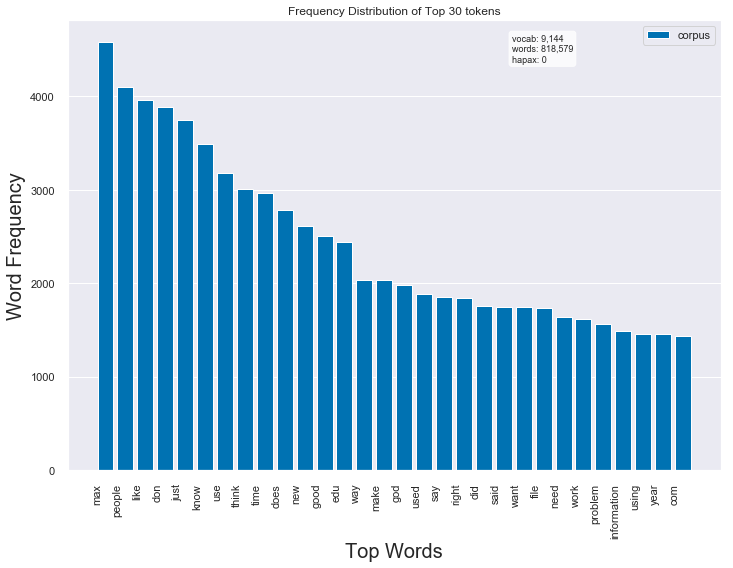

In [10]:
from yellowbrick.style import set_palette
set_palette('colorblind')
# instantiate fitting the model
docs = tf_vectorizer.fit_transform(news_raw)
features = tf_vectorizer.get_feature_names()

# limit the number of words shown at 30
visualizer = FreqDistVisualizer(features=features, n=30, orient='v')
visualizer.fit(docs)

#formatting the chart
plt.ylabel("Word Frequency", fontsize=20)
plt.xlabel("Top Words", fontsize=20)
plt.figure(figsize=(30, 15))

#show visualization
visualizer.poof()

## Top 30 with stop words

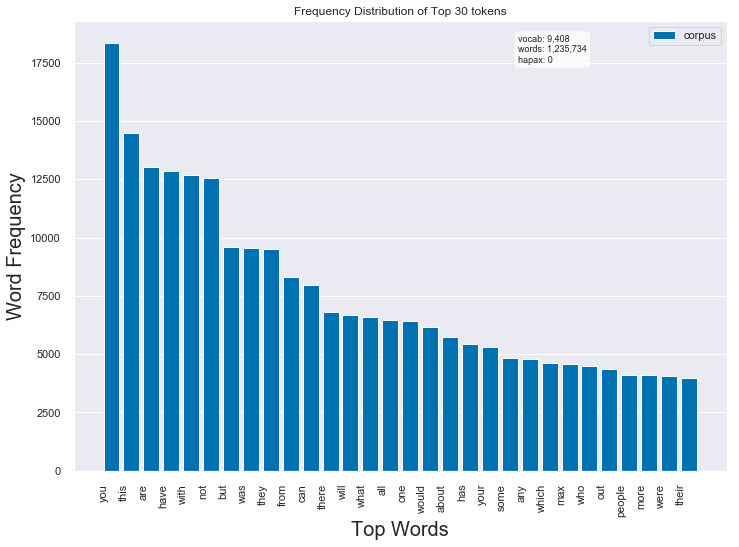

In [11]:
# instantiate fitting the model
docs_stop = tf_vectorizer_stop.fit_transform(news_raw)
features_stop = tf_vectorizer_stop.get_feature_names()

# limit the number of words shown at 30
visualizer_stop = FreqDistVisualizer(features=features_stop, n=30, orient='v')
visualizer_stop.fit(docs_stop)

#formatting the chart
plt.ylabel("Word Frequency", fontsize=20)
plt.xlabel("Top Words", fontsize=20)
plt.figure(figsize=(30, 15))


#show visualization
visualizer_stop.poof()

## We can tell the corpus is working by seeing the top 23 stop words appearing more frequently than "max," which was the most common word in the corpus (?) without stop words.

FreqDistVisualizer documentation: https://www.scikit-yb.org/en/latest/api/text/freqdist.html

## Visualizing all of the 11,314 documents using t-SNE

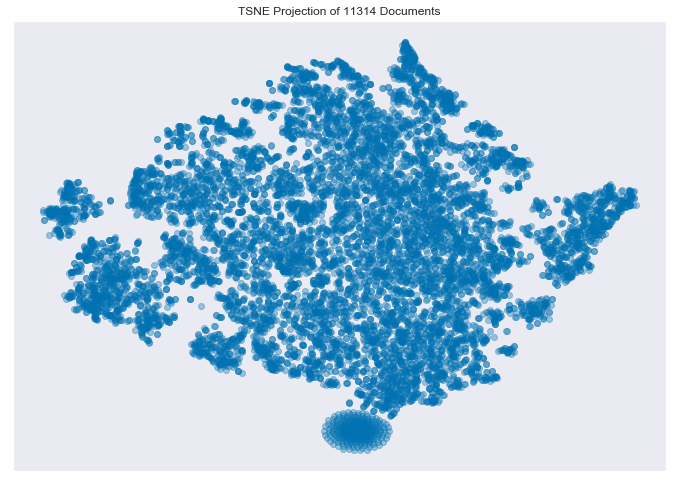

CPU times: user 2min 8s, sys: 8.47 s, total: 2min 17s
Wall time: 2min 17s


In [12]:
%%time
# Load the data and instantiate TSNE
tsne = TSNEVisualizer(ax=None, decompose='svd', decompose_by=20, labels=None, 
                      classes=None, colors=None, colormap=None, random_state=61, 
                      alpha=0.35)
# fit 
tsne.fit(docs)
# visualize
tsne.poof()

## Visualizing all the documents by topic

In [14]:
# The list of 20 publications 
news.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

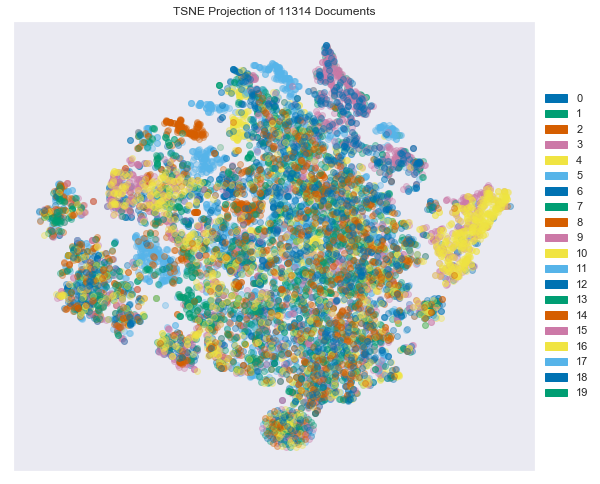

CPU times: user 3min 37s, sys: 15.8 s, total: 3min 53s
Wall time: 5min 40s


In [46]:
%%time

# specify labels
labels = news.target_names

docs = tf_vectorizer.fit_transform(news.data)
X = docs
y = news.target

# Create the visualizer and draw the vectors
tsne_color = TSNEVisualizer(random_state=61, alpha=0.35, decompose_by=20,
                            labels=labels)

tsne_color.fit(X, y)
tsne_color.poof()

yellowbrick's t-SNE documentation: https://www.scikit-yb.org/en/latest/api/text/tsne.html

## Judging from the News Sources, there are roughly 7 topics: 
## - computers & electronics
## - for-sales items 
## - cars & bikes/automobiles
## - sports 
## - science  
## - religion
## - politics
## (A few of these could feasibly be subdivided further.)

# CountVectorizer Document Visualization

sources: https://www.youtube.com/watch?v=UkmIljRIG_M

In [15]:
# instantiating the model; EXCLUDING stop words
lda_tf10 = LatentDirichletAllocation(n_topics=10,
                                     random_state=36)
lda_tf10.fit(dtm_tf)

lda_tf5 = LatentDirichletAllocation(n_topics=5,
                                    random_state=36)
lda_tf5.fit(dtm_tf)

# instantiating the model; INCLUDING stop words
lda_tf10_stop = LatentDirichletAllocation(n_topics=10,
                                          random_state=36)
lda_tf10_stop.fit(dtm_tf_stop)

lda_tf5_stop = LatentDirichletAllocation(n_topics=5,
                                     random_state=36)
lda_tf5_stop.fit(dtm_tf_stop)


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=5, perp_tol=0.1,
             random_state=36, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

# pyLDAvis - Excluding stop words

## 10 Topics

In [16]:
pyLDAvis.sklearn.prepare(lda_tf10, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      15.496871        1       1  0.141031  0.027042
9      14.600841        1       2  0.084689 -0.065014
3      12.602951        1       3 -0.121044  0.080294
8      10.501119        1       4 -0.240718  0.009917
0      10.467467        1       5  0.063285 -0.114917
2      10.143905        1       6 -0.173016  0.038355
1       8.588988        1       7  0.026019 -0.074793
5       7.058704        1       8  0.126729  0.272968
6       6.290237        1       9 -0.043073 -0.104488
7       4.248917        1      10  0.136097 -0.069365, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
5016  Default  4443.000000             max  4443.000000  30.0000  30.0000
2653  Default  2402.000000             edu  2402.000000  29.0000  29.0000
3523  Default  1954.000000             god  1954.000000  28.0000  28.0000
4497  Default  1198.000000             key  1198.000000  27.0000  27.0000
7677  Default  1265.000000           space  1265.000000  26.0000  26.0000
3153  Default  1721.000000            file  1721.000000  25.0000  25.0000
8982  Default  1226.000000         windows  1226.000000  24.0000  24.0000
3405  Default   809.000000            game   809.000000  23.0000  23.0000
2560  Default  1112.000000           drive  1112.000000  22.0000  22.0000
8167  Default   755.000000            team   755.000000  21.0000  21.0000
1506  Default  1418.000000             com  1418.000000  20.0000  20.0000
4396  Default   875.000000           jesus   875.000000  19.0000  19.0000
6263  Default   643.000000       president   643.000000  18.0000  18.0000
8675  Default  3143.000000             use  3143.000000  17.0000  17.0000
6362  Default  1372.000000         program  1372.000000  16.0000  16.0000
5924  Default  4081.000000          people  4081.000000  15.0000  15.0000
3551  Default  1225.000000      government  1225.000000  14.0000  14.0000
8278  Default  2979.000000           think  2979.000000  13.0000  13.0000
2747  Default   542.000000      encryption   542.000000  12.0000  12.0000
1322  Default   694.000000            chip   694.000000  11.0000  11.0000
3639  Default   718.000000             gun   718.000000  10.0000  10.0000
1161  Default   787.000000            card   787.000000   9.0000   9.0000
804   Default   442.000000             bhj   442.000000   8.0000   8.0000
3406  Default   551.000000           games   551.000000   7.0000   7.0000
8981  Default   778.000000          window   778.000000   6.0000   6.0000
3497  Default   420.000000             giz   420.000000   5.0000   5.0000
627   Default  1292.000000       available  1292.000000   4.0000   4.0000
3528  Default  1393.000000           going  1393.000000   3.0000   3.0000
7250  Default   638.000000            scsi   638.000000   2.0000   2.0000
9111  Default  1431.000000            year  1431.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
2170  Topic10    40.221746         deficit    46.634788   3.0106  -6.7624
3261  Topic10    44.336509           foods    53.459095   2.9714  -6.6650
3388  Topic10    82.897698           funds   112.065482   2.8570  -6.0392
8156  Topic10    74.920719           taxes    99.694557   2.8728  -6.1404
7278  Topic10    99.596073       secretary   149.518427   2.7522  -5.8557
1423  Topic10   158.303996         clinton   274.480029   2.6081  -5.3923
822   Topic10    98.324772         billion   148.106149   2.7489  -5.8685
1029  Topic10    82.754845          budget   122.008104   2.7703  -6.0409
5249  Topic10   242.472774           money   552.734125   2.3345  -4.9659
219   Topic10   185.055745             air   387.095482   2.4205  -5.2362
7333  Topic10    66.987138          senior    91.565322   2.8460  -6.2523
2639  Topic10    68.074577         economy    96.8815

## 5 Topics

In [17]:
pyLDAvis.sklearn.prepare(lda_tf5, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      27.520152        1       1 -0.110282  0.011490
2      19.610738        1       2  0.115725 -0.110689
1      19.252049        1       3 -0.077647  0.135248
4      18.930851        1       4 -0.165473 -0.082219
3      14.686210        1       5  0.237677  0.046169, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
5016  Default  4433.000000          max  4433.000000  30.0000  30.0000
3523  Default  1900.000000          god  1900.000000  29.0000  29.0000
2653  Default  2367.000000          edu  2367.000000  28.0000  28.0000
4497  Default  1185.000000          key  1185.000000  27.0000  27.0000
8982  Default  1245.000000      windows  1245.000000  26.0000  26.0000
3153  Default  1734.000000         file  1734.000000  25.0000  25.0000
4396  Default   851.000000        jesus   851.000000  24.0000  24.0000
1506  Default  1400.000000          com  1400.000000  23.0000  23.0000
7677  Default  1284.000000        space  1284.000000  22.0000  22.0000
4895  Default  1174.000000         mail  1174.000000  21.0000  21.0000
627   Default  1282.000000    available  1282.000000  20.0000  20.0000
1322  Default   684.000000         chip   684.000000  19.0000  19.0000
8675  Default  3166.000000          use  3166.000000  18.0000  18.0000
2560  Default  1127.000000        drive  1127.000000  17.0000  17.0000
3405  Default   798.000000         game   798.000000  16.0000  16.0000
1157  Default   801.000000          car   801.000000  15.0000  15.0000
3551  Default  1238.000000   government  1238.000000  14.0000  14.0000
7629  Default   950.000000     software   950.000000  13.0000  13.0000
3365  Default   738.000000          ftp   738.000000  12.0000  12.0000
457   Default   614.000000     armenian   614.000000  11.0000  11.0000
8981  Default   790.000000       window   790.000000  10.0000  10.0000
2077  Default  1225.000000         data  1225.000000   9.0000   9.0000
2747  Default   535.000000   encryption   535.000000   8.0000   8.0000
8167  Default   746.000000         team   746.000000   7.0000   7.0000
8252  Default  1255.000000       thanks  1255.000000   6.0000   6.0000
5924  Default  4077.000000       people  4077.000000   5.0000   5.0000
6460  Default   528.000000          pub   528.000000   4.0000   4.0000
4134  Default  1460.000000  information  1460.000000   3.0000   3.0000
2517  Default   716.000000          dos   716.000000   2.0000   2.0000
3639  Default   716.000000          gun   716.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
348    Topic5   389.794379    anonymous   419.711882   1.8443  -5.7314
5970   Topic5   136.376777          pgp   141.300014   1.8828  -6.7816
6315   Topic5   315.020298      privacy   353.195603   1.8039  -5.9444
5448   Topic5    90.810971     networks    92.866220   1.8959  -7.1883
7441   Topic5   226.248220     shipping   248.278950   1.8253  -6.2754
2653   Topic5  1800.643055          edu  2367.999568   1.6444  -4.2012
3099   Topic5   283.952085          fax   320.377701   1.7976  -6.0483
3940   Topic5   325.985908          ibm   375.014567   1.7782  -5.9102
2689   Topic5   201.996710   electronic   222.085076   1.8235  -6.3888
8143   Topic5   213.182854          tar   239.783820   1.8007  -6.3349
5989   Topic5   399.357367        phone   485.835323   1.7222  -5.7072
3365   Topic5   575.421151          ftp   738.022388   1.6694  -5.3420
1506   Topic5   946.827087          com  1400.914186   1.5265  -4.8439
4895   Topic5   803.576673         mail  1174.131904   1.5390  -5.0080
627    Topic5   854.633927    available  1282.766336   1.5122  -4.9464
7146   Topic5   278.121619         sale   334.438855   1.7339  -6.0690
2704   Topic5   490.589063        email   743.824047   1.5021  -5.5015
1629   Topic5   493.764542   

# Of the two, the 10 topic CountVectorizer had the most distinct topics.

# pyLDAvis - Including stop words

## 10 Topics 

In [18]:
pyLDAvis.sklearn.prepare(lda_tf10_stop, dtm_tf_stop, tf_vectorizer_stop)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      24.985025        1       1 -0.059035 -0.024080
7      13.293946        1       2 -0.064433 -0.084200
5       9.915754        1       3 -0.060293 -0.124519
3       9.367194        1       4  0.136323  0.027146
1       8.873689        1       5  0.092494 -0.064291
2       8.569032        1       6 -0.003638  0.027510
9       8.422560        1       7  0.194333  0.007034
0       6.651808        1       8 -0.231334 -0.046191
8       5.663498        1       9 -0.139954  0.225877
6       4.257494        1      10  0.135538  0.055714, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
5139  Default   4472.000000         max   4472.000000  30.0000  30.0000
9122  Default   9472.000000         was   9472.000000  29.0000  29.0000
2714  Default   2431.000000         edu   2431.000000  28.0000  28.0000
9179  Default   4009.000000        were   4009.000000  27.0000  27.0000
8481  Default   9440.000000        they   9440.000000  26.0000  26.0000
9384  Default  18345.000000         you  18345.000000  25.0000  25.0000
3618  Default   1963.000000         god   1963.000000  24.0000  24.0000
3232  Default   1744.000000        file   1744.000000  23.0000  23.0000
3926  Default   3310.000000         his   3310.000000  22.0000  22.0000
1557  Default   1433.000000         com   1433.000000  21.0000  21.0000
3749  Default   3459.000000         had   3459.000000  20.0000  20.0000
4613  Default   1216.000000         key   1216.000000  19.0000  19.0000
9389  Default   5309.000000        your   5309.000000  18.0000  18.0000
7870  Default   1275.000000       space   1275.000000  17.0000  17.0000
9236  Default   1215.000000     windows   1215.000000  16.0000  16.0000
3498  Default    807.000000        game    807.000000  15.0000  15.0000
7597  Default    948.000000         she    948.000000  14.0000  14.0000
6256  Default   1492.000000      please   1492.000000  13.0000  13.0000
8364  Default    754.000000        team    754.000000  12.0000  12.0000
2618  Default   1096.000000       drive   1096.000000  11.0000  11.0000
6091  Default   4090.000000      people   4090.000000  10.0000  10.0000
1212  Default    774.000000        card    774.000000   9.0000   9.0000
4511  Default    880.000000       jesus    880.000000   8.0000   8.0000
8451  Default   1238.000000      thanks   1238.000000   7.0000   7.0000
3887  Default    847.000000         her    847.000000   6.0000   6.0000
3918  Default   1588.000000         him   1588.000000   5.0000   5.0000
5653  Default  12484.000000         not  12484.000000   4.0000   4.0000
1208  Default    786.000000         car    786.000000   3.0000   3.0000
7313  Default   1726.000000        said   1726.000000   2.0000   2.0000
3646  Default   1226.000000  government   1226.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
123   Topic10    205.604456     address    612.413804   2.0650  -5.5447
4241  Topic10    210.209312        info    685.923572   1.9738  -5.5226
5017  Topic10    289.301841        mail   1193.086076   1.7397  -5.2032
8451  Topic10    284.683066      thanks   1238.160796   1.6865  -5.2193
508   Topic10    190.391946     article    617.419453   1.9800  -5.6216
7018  Topic10    123.603287       reply    300.512900   2.2681  -6.0536
9389  Topic10    478.626408        your   5309.458926   0.7502  -4.6998
8493  Topic10    699.977706        this  14439.950359   0.1298  -4.3196
4876  Topic10    197.201997        line    907.455899   1.6301  -5.5865
9384  Topic10    685.954233         you  18345.196999  -0.1298  -4.3399
7044  Topic10    131.373812     request    347.467257   2.1839  -5.9926
7122  Topic10    135.739713      return    410.744366   2.0493  -5.9599
6340  Topic10    170.671655        post    784.227236   1.6315  -5.73

## 5 Topics

In [19]:
pyLDAvis.sklearn.prepare(lda_tf5_stop, dtm_tf_stop, tf_vectorizer_stop)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      34.697579        1       1  0.038901 -0.065429
3      19.631362        1       2 -0.156192 -0.059447
2      19.473279        1       3  0.009077 -0.094866
1      13.605697        1       4 -0.099532  0.167696
0      12.592083        1       5  0.207745  0.052046, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
5139  Default   4434.000000          max   4434.000000  30.0000  30.0000
9122  Default   9433.000000          was   9433.000000  29.0000  29.0000
9384  Default  18270.000000          you  18270.000000  28.0000  28.0000
9179  Default   3991.000000         were   3991.000000  27.0000  27.0000
8481  Default   9392.000000         they   9392.000000  26.0000  26.0000
3926  Default   3295.000000          his   3295.000000  25.0000  25.0000
3618  Default   1962.000000          god   1962.000000  24.0000  24.0000
7870  Default   1286.000000        space   1286.000000  23.0000  23.0000
3749  Default   3449.000000          had   3449.000000  22.0000  22.0000
9236  Default   1227.000000      windows   1227.000000  21.0000  21.0000
4613  Default   1224.000000          key   1224.000000  20.0000  20.0000
3232  Default   1726.000000         file   1726.000000  19.0000  19.0000
6532  Default   1384.000000      program   1384.000000  18.0000  18.0000
2714  Default   2419.000000          edu   2419.000000  17.0000  17.0000
4245  Default   1479.000000  information   1479.000000  16.0000  16.0000
8905  Default   3168.000000          use   3168.000000  15.0000  15.0000
3918  Default   1578.000000          him   1578.000000  14.0000  14.0000
2131  Default   1241.000000         data   1241.000000  13.0000  13.0000
8364  Default    752.000000         team    752.000000  12.0000  12.0000
9206  Default   4419.000000          who   4419.000000  11.0000  11.0000
3498  Default    808.000000         game    808.000000  10.0000  10.0000
483   Default    592.000000     armenian    592.000000   9.0000   9.0000
7815  Default    956.000000     software    956.000000   8.0000   8.0000
1212  Default    790.000000         card    790.000000   7.0000   7.0000
8305  Default   2000.000000       system   2000.000000   6.0000   6.0000
1208  Default    805.000000          car    805.000000   5.0000   5.0000
8455  Default   3948.000000        their   3948.000000   4.0000   4.0000
7313  Default   1714.000000         said   1714.000000   3.0000   3.0000
2574  Default    708.000000          dos    708.000000   2.0000   2.0000
654   Default   1304.000000    available   1304.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
9179   Topic5   1792.704707         were   3991.211559   1.2717  -4.4636
4468   Topic5    390.746528       israel    543.277003   1.7425  -5.9870
9105   Topic5    364.198188          war    501.471716   1.7523  -6.0574
9122   Topic5   3055.273616          was   9433.535225   0.9447  -3.9304
4516   Topic5    365.562927         jews    541.871468   1.6785  -6.0536
3749   Topic5   1244.671050          had   3449.354322   1.0528  -4.8284
9178   Topic5    366.354978         went    553.645617   1.6592  -6.0515
8481   Topic5   2129.775649         they   9392.997234   0.5882  -4.2913
3926   Topic5   1085.187696          his   3295.058345   0.9614  -4.9656
7313   Topic5    627.166540         said   1714.455535   1.0665  -5.5139
3918   Topic5    591.229372          him   1578.478949   1.0901  -5.5729
8455   Topic5    939.739938        their   3948.737089   0.6366  -5.1095
9369   Topic5    542.441924         year   1439.958341   1.0958  -5.6590
3449   Topic5   1143.811044         from   8248.641858   0.0964  -4.9130
9206   Topic5    794.735901          who   4419.891957   0.3562  -5.2771
9267   Topic5   1180.677956         with  12583.483613  -0.2942  -4.8812
58

# With the stop words included, the model struggled to identify topics. In this case, it would be better to remove the stop words.

# Part 2: TF-IDF Document Visualization 

TF-IDF EXCLUDING stop words

In [20]:
# Converts a collection of raw documents to a matrix of TF-IDF features.
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
# fit the model 
dtm_tfidf = tfidf_vectorizer.fit_transform(news_raw)
# print shape
print(dtm_tfidf.shape)

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


(11314, 9144)


TF-IDF INCLUDING stop words

In [21]:
# Converts a collection of raw documents to a matrix of TF-IDF features.
tfidf_vectorizer_stop = TfidfVectorizer(**tf_vectorizer_stop.get_params())
# fit the model 
dtm_tfidf_stop = tfidf_vectorizer_stop.fit_transform(news_raw)
# print shape
print(dtm_tfidf_stop.shape)

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


(11314, 9408)


https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [22]:
# instantiating the model for 5 and 10 topics; EXCLUDING stop words
lda_tfidf10 = LatentDirichletAllocation(n_topics=10,
                                     random_state=36)
lda_tfidf10.fit(dtm_tfidf)

lda_tfidf5 = LatentDirichletAllocation(n_topics=5,
                                    random_state=36)
lda_tfidf5.fit(dtm_tfidf)

# instantiating the model for 5 and 10 topics; INCLUDING stop words
lda_tfidf10_stop = LatentDirichletAllocation(n_topics=10,
                                          random_state=36)
lda_tfidf10_stop.fit(dtm_tfidf_stop)

lda_tfidf5_stop = LatentDirichletAllocation(n_topics=5,
                                     random_state=36)
lda_tfidf5_stop.fit(dtm_tfidf_stop)


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=5, perp_tol=0.1,
             random_state=36, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

# pyLDAvis - Excluding stop words

# 10 Topics

In [23]:
pyLDAvis.sklearn.prepare(lda_tfidf10, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      32.380367        1       1 -0.024728 -0.089898
7      23.281143        1       2 -0.053599 -0.051552
8      16.182689        1       3 -0.199842  0.018058
2      10.796458        1       4 -0.201705  0.068375
0       5.610185        1       5  0.044910 -0.186607
6       3.098683        1       6  0.079090  0.099325
5       2.481570        1       7  0.099032  0.045979
9       2.159974        1       8  0.089082  0.031843
1       2.095725        1       9  0.094577  0.038815
3       1.913206        1      10  0.073183  0.025661, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
4497  Default   52.000000          key   52.000000  30.0000  30.0000
2653  Default   89.000000          edu   89.000000  29.0000  29.0000
8982  Default   77.000000      windows   77.000000  28.0000  28.0000
8167  Default   42.000000         team   42.000000  27.0000  27.0000
3405  Default   50.000000         game   50.000000  26.0000  26.0000
1322  Default   42.000000         chip   42.000000  25.0000  25.0000
8252  Default  111.000000       thanks  111.000000  24.0000  24.0000
2747  Default   26.000000   encryption   26.000000  23.0000  23.0000
9111  Default   65.000000         year   65.000000  22.0000  22.0000
3153  Default   54.000000         file   54.000000  21.0000  21.0000
3551  Default   51.000000   government   51.000000  20.0000  20.0000
3406  Default   39.000000        games   39.000000  19.0000  19.0000
7657  Default   28.000000         soon   28.000000  18.0000  18.0000
1425  Default   25.000000      clipper   25.000000  17.0000  17.0000
1506  Default   62.000000          com   62.000000  16.0000  16.0000
8675  Default  113.000000          use  113.000000  15.0000  15.0000
3639  Default   32.000000          gun   32.000000  14.0000  14.0000
3156  Default   40.000000        files   40.000000  13.0000  13.0000
4500  Default   23.000000         keys   23.000000  12.0000  12.0000
1161  Default   59.000000         card   59.000000  11.0000  11.0000
2560  Default   70.000000        drive   70.000000  10.0000  10.0000
8981  Default   42.000000       window   42.000000   9.0000   9.0000
6362  Default   54.000000      program   54.000000   8.0000   8.0000
6080  Default   26.000000      players   26.000000   7.0000   7.0000
3523  Default   83.000000          god   83.000000   6.0000   6.0000
7266  Default   24.000000       season   24.000000   5.0000   5.0000
8235  Default   25.000000         test   25.000000   4.0000   4.0000
6038  Default   16.000000         pitt   16.000000   3.0000   3.0000
3538  Default   16.000000       gordon   16.000000   2.0000   2.0000
3365  Default   32.000000          ftp   32.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
3728  Topic10    2.696200         hawk    4.114869   3.5336  -6.0132
9094  Topic10    1.870177       ximage    2.890691   3.5209  -6.3790
2857  Topic10    1.823281       ethics    2.850704   3.5095  -6.4044
4843  Topic10    1.964111   louisville    3.089663   3.5034  -6.3300
3389  Topic10    1.511109        funet    2.379652   3.5023  -6.5922
146   Topic10    1.912245       adress    3.019498   3.4996  -6.3568
2278  Topic10    1.507368  destination    2.386279   3.4970  -6.5947
1298  Topic10    2.951744        cheat    4.706074   3.4899  -5.9227
5778  Topic10    1.336166      packing    2.229736   3.4443  -6.7152
4327  Topic10    1.892747      ireland    3.234179   3.4206  -6.3670
2028  Topic10    1.622555       curves    2.776672   3.4191  -6.5210
8692  Topic10    1.496815         util    2.603624   3.4028  -6.6017
5465  Topic10    1.543289          nic    2.686550   3.4020  -6.5711
4719  Topic10    1.423550      licence    2.506513   3.3907  -6.6519
3813  Topic10    2.385950      hillary    4.226210   3.3847  -6.13

# 5 Topics

In [24]:
pyLDAvis.sklearn.prepare(lda_tfidf5, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      56.418530        1       1  0.024697  0.071142
2      24.570320        1       2 -0.153494  0.028205
0       7.918164        1       3  0.112647  0.069135
3       6.387904        1       4 -0.071717 -0.060085
1       4.705081        1       5  0.087868 -0.108397, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
8252  Default  112.000000      thanks  112.000000  30.0000  30.0000
7677  Default   49.000000       space   49.000000  29.0000  29.0000
8982  Default   80.000000     windows   80.000000  28.0000  28.0000
2653  Default   90.000000         edu   90.000000  27.0000  27.0000
4497  Default   49.000000         key   49.000000  26.0000  26.0000
4895  Default   69.000000        mail   69.000000  25.0000  25.0000
1161  Default   59.000000        card   59.000000  24.0000  24.0000
7146  Default   35.000000        sale   35.000000  23.0000  23.0000
2560  Default   70.000000       drive   70.000000  22.0000  22.0000
2704  Default   50.000000       email   50.000000  21.0000  21.0000
4355  Default   30.000000      israel   30.000000  20.0000  20.0000
6285  Default   41.000000       price   41.000000  19.0000  19.0000
5452  Default   99.000000         new   99.000000  18.0000  18.0000
3551  Default   50.000000  government   50.000000  17.0000  17.0000
120   Default   39.000000     address   39.000000  16.0000  16.0000
5615  Default   31.000000       offer   31.000000  15.0000  15.0000
4244  Default   44.000000  interested   44.000000  14.0000  14.0000
3153  Default   55.000000        file   55.000000  13.0000  13.0000
7657  Default   28.000000        soon   28.000000  12.0000  12.0000
7441  Default   25.000000    shipping   25.000000  11.0000  11.0000
1506  Default   63.000000         com   63.000000  10.0000  10.0000
2493  Default  129.000000        does  129.000000   9.0000   9.0000
2747  Default   24.000000  encryption   24.000000   8.0000   8.0000
8777  Default   37.000000       video   37.000000   7.0000   7.0000
2517  Default   43.000000         dos   43.000000   6.0000   6.0000
4821  Default   58.000000     looking   58.000000   5.0000   5.0000
4874  Default   39.000000         mac   39.000000   4.0000   4.0000
8675  Default  114.000000         use  114.000000   3.0000   3.0000
5372  Default   22.000000        nasa   22.000000   2.0000   2.0000
7629  Default   48.000000    software   48.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
7678   Topic5    7.388783  spacecraft    8.068018   2.9686  -5.9050
8050   Topic5   13.928154   surrender   15.636885   2.9408  -5.2710
7172   Topic5    7.716644   satellite    8.739524   2.9321  -5.8615
354    Topic5    6.131953     antenna    7.006317   2.9232  -6.0914
4977   Topic5    4.792592        mars    5.476719   2.9231  -6.3378
4464   Topic5    4.502885     jupiter    5.182808   2.9159  -6.4002
674    Topic5    4.213249      baerga    4.901448   2.9052  -6.4667
5689   Topic5    4.144257     orbital    4.824373   2.9046  -6.4832
7173   Topic5    3.998698  satellites    4.673553   2.9006  -6.5189
1198   Topic5    3.859620     catbyte    4.532929   2.8957  -6.5543
2582   Topic5    3.859620     dtmedin    4.532929   2.8957  -6.5543
4140   Topic5    3.840143        ingr    4.514171   2.8948  -6.5594
1013   Topic5    3.825978       bronx    4.504904   2.8932  -6.5631
4933   Topic5    3.830450   manhattan    4.511203   2.8929  -6.5619
8654   Topic5    3.868120       upenn    4.572749   2.8892  -6.5521
819    Topic5    3.662539       biker    4.355775   2.8832  -6.6068
7768   Topic5    3.459924        ssto    4.134581   2.8784  -6.6637
890    Topic5    3.394409       bobbe    4.067397   2.8757  -6.6828
4614   Topic5   11.299090      launch   13.631521   2.8689  -5.4802
4863   Topic5    7.890700       lunar    9.

# Of the two, the 10 topic TF-IDF had the most distinct and accurate words in each

# pyLDAvis - Including stop words

In [25]:
pyLDAvis.sklearn.prepare(lda_tfidf10_stop, dtm_tfidf_stop, tfidf_vectorizer_stop)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      78.981190        1       1 -0.088560 -0.034806
2       5.454214        1       2 -0.257186 -0.039870
6       4.488314        1       3  0.106145 -0.225794
3       1.778107        1       4  0.006173  0.045244
9       1.775291        1       5  0.052435  0.063320
0       1.580732        1       6  0.041323  0.047910
8       1.522605        1       7  0.037912  0.039137
7       1.502007        1       8  0.036134  0.037867
1       1.461427        1       9  0.033730  0.034101
5       1.456113        1      10  0.031895  0.032890, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
9267  Default  267.000000       with  267.000000  30.0000  30.0000
3821  Default  295.000000       have  295.000000  29.0000  29.0000
8451  Default  105.000000     thanks  105.000000  28.0000  28.0000
2618  Default   67.000000      drive   67.000000  27.0000  27.0000
1177  Default  213.000000        can  213.000000  26.0000  26.0000
1212  Default   57.000000       card   57.000000  25.0000  25.0000
2549  Default  118.000000       does  118.000000  24.0000  24.0000
9236  Default   76.000000    windows   76.000000  23.0000  23.0000
378   Default  165.000000        any  165.000000  22.0000  22.0000
6256  Default   93.000000     please   93.000000  21.0000  21.0000
382   Default  105.000000     anyone  105.000000  20.0000  20.0000
9122  Default  235.000000        was  235.000000  19.0000  19.0000
3926  Default  103.000000        his  103.000000  18.0000  18.0000
9369  Default   60.000000       year   60.000000  17.0000  17.0000
3498  Default   48.000000       game   48.000000  16.0000  16.0000
4659  Default  138.000000       know  138.000000  15.0000  15.0000
8305  Default   75.000000     system   75.000000  14.0000  14.0000
8364  Default   40.000000       team   40.000000  13.0000  13.0000
2714  Default   86.000000        edu   86.000000  12.0000  12.0000
1557  Default   60.000000        com   60.000000  11.0000  11.0000
7318  Default   35.000000       sale   35.000000  10.0000  10.0000
8481  Default  234.000000       they  234.000000   9.0000   9.0000
8905  Default  106.000000        use  106.000000   8.0000   8.0000
5017  Default   66.000000       mail   66.000000   7.0000   7.0000
8589  Default   73.000000        too   73.000000   6.0000   6.0000
3570  Default  131.000000        get  131.000000   5.0000   5.0000
4718  Default   54.000000       last   54.000000   4.0000   4.0000
5547  Default   78.000000       need   78.000000   3.0000   3.0000
8474  Default  188.000000      there  188.000000   2.0000   2.0000
9225  Default  173.000000       will  173.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
1880  Topic10    1.579464     convex    2.551467   3.7498  -6.4455
5036  Topic10    1.390058   makefile    2.257568   3.7445  -6.5732
3556  Topic10    1.523882        geo    2.513705   3.7289  -6.4813
302   Topic10    2.488864        amd    4.480264   3.6415  -5.9907
6057  Topic10    1.009506  patterson    2.001912   3.5448  -6.8931
107   Topic10    5.552948       adam   11.776097   3.4777  -5.1882
2128  Topic10    1.824515        das    4.545512   3.3166  -6.3013
4804  Topic10    1.701589       lens    4.779873   3.1965  -6.3710
2429  Topic10    0.668008  directive    1.911976   3.1778  -7.3060
887   Topic10    0.765635       bite    2.939106   2.8842  -7.1696
7628  Topic10    0.776714    shocked    3.174786   2.8215  -7.1553
7273  Topic10    0.608135      ruins    2.498314   2.8164  -7.3999
7635  Topic10    0.635486      shops    2.639565   2.8054  -7.3559
9188  Topic10    0.786310      whats    3.266310   2.8053  -7.1430
3511  Topic10    0.638555     gatech    2.678330   2.7957  -7.3511
2876  Topic10    0.449536        eos    1.889612   2.7935  -7.7021
2713  Topic10    0.880630 

In [26]:
pyLDAvis.sklearn.prepare(lda_tfidf5_stop, dtm_tfidf_stop, tfidf_vectorizer_stop)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      83.367643        1       1 -0.091566  0.117279
0       7.079800        1       2 -0.102504 -0.109703
2       3.324707        1       3  0.066936 -0.016087
1       3.276027        1       4  0.068488  0.007263
3       2.951822        1       5  0.058646  0.001248, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
9122  Default  235.000000         was  235.000000  30.0000  30.0000
8481  Default  235.000000        they  235.000000  29.0000  29.0000
2618  Default   67.000000       drive   67.000000  28.0000  28.0000
7318  Default   36.000000        sale   36.000000  27.0000  27.0000
3498  Default   48.000000        game   48.000000  26.0000  26.0000
3926  Default  104.000000         his  104.000000  25.0000  25.0000
9369  Default   61.000000        year   61.000000  24.0000  24.0000
7423  Default   33.000000        scsi   33.000000  23.0000  23.0000
8364  Default   40.000000        team   40.000000  22.0000  22.0000
2714  Default   86.000000         edu   86.000000  21.0000  21.0000
5767  Default   31.000000       offer   31.000000  20.0000  20.0000
1557  Default   60.000000         com   60.000000  19.0000  19.0000
8589  Default   73.000000         too   73.000000  18.0000  18.0000
2770  Default   48.000000       email   48.000000  17.0000  17.0000
7621  Default   25.000000    shipping   25.000000  16.0000  16.0000
4718  Default   54.000000        last   54.000000  15.0000  15.0000
3499  Default   37.000000       games   37.000000  14.0000  14.0000
1710  Default   25.000000   condition   25.000000  13.0000  13.0000
3918  Default   59.000000         him   59.000000  12.0000  12.0000
3630  Default  101.000000        good  101.000000  11.0000  11.0000
1119  Default  228.000000         but  228.000000  10.0000  10.0000
839   Default   47.000000        best   47.000000   9.0000   9.0000
526   Default   23.000000      asking   23.000000   8.0000   8.0000
1112  Default   26.000000         bus   26.000000   7.0000   7.0000
1858  Default   23.000000  controller   23.000000   6.0000   6.0000
8488  Default  116.000000       think  116.000000   5.0000   5.0000
6455  Default   39.000000       price   39.000000   4.0000   4.0000
3274  Default   74.000000       first   74.000000   3.0000   3.0000
6245  Default   29.000000        play   29.000000   2.0000   2.0000
6249  Default   25.000000     players   25.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
8384   Topic5    5.460143         tek    6.661616   3.3239  -5.9117
774    Topic5    3.241057  beauchaine    3.958882   3.3227  -6.4333
7336   Topic5    3.270039        sank    4.005697   3.3198  -6.4244
9342   Topic5    2.994061       wustl    3.784020   3.2886  -6.5126
5497   Topic5    2.777608        nada    3.512818   3.2879  -6.5876
9398   Topic5    2.644586      zenith    3.393595   3.2734  -6.6367
2254   Topic5    2.390124      deluxe    3.130601   3.2529  -6.7379
4829   Topic5    6.399312         lib    8.573999   3.2302  -5.7530
8922   Topic5    1.915933        util    2.644585   3.2004  -6.9590
909    Topic5    3.376795        blew    4.990972   3.1320  -6.3923
2056   Topic5    1.654517        csrc    2.643022   3.0543  -7.1057
3461   Topic5    2.034806     fujitsu    3.347768   3.0249  -6.8988
8206   Topic5    1.715858      sunset    3.084126   2.9364  -7.0693
7578   Topic5    3.463096       shaft    6.533492   2.8880  -6.3671
1403   Topic5    5.288165        cica   10.000731   2.8856  -5.9437
3747   Topic5    1.799267      hacker    3.529787   2.8489  -7.0218
7912   Topic5    3.368921   speedstar    6.640047   2.8442  -6.3946
7821   Topic5    1.821507    soldered    3.598666   2.8418  -7.0096
8204   Topic5    1.674537     sunrise    3.336352   2.8334  -7.0937
8930   Topic5    1.159766    uudecode    2.

## Just as with CountVectorizer, in TF-IDF the model struggled to find the specific topics. In this instance, TF-IDF with stop words does not seem the best in this example.

# Section IV: Tuning the model

## Since the 10-topic model was sensitive enough to accurately detect various topics, there are different ways to visualize the data to make it more persuasive. Tuning the multi-dimensional scaling (mds) hyperparameter

## Principal Coordinate Analysis (default setting)

In [27]:
pyLDAvis.sklearn.prepare(lda_tfidf10, dtm_tfidf, tfidf_vectorizer, mds='pcoa')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      32.380367        1       1 -0.024728 -0.089898
7      23.281143        1       2 -0.053599 -0.051552
8      16.182689        1       3 -0.199842  0.018058
2      10.796458        1       4 -0.201705  0.068375
0       5.610185        1       5  0.044910 -0.186607
6       3.098683        1       6  0.079090  0.099325
5       2.481570        1       7  0.099032  0.045979
9       2.159974        1       8  0.089082  0.031843
1       2.095725        1       9  0.094577  0.038815
3       1.913206        1      10  0.073183  0.025661, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
4497  Default   52.000000          key   52.000000  30.0000  30.0000
2653  Default   89.000000          edu   89.000000  29.0000  29.0000
8982  Default   77.000000      windows   77.000000  28.0000  28.0000
8167  Default   42.000000         team   42.000000  27.0000  27.0000
3405  Default   50.000000         game   50.000000  26.0000  26.0000
1322  Default   42.000000         chip   42.000000  25.0000  25.0000
8252  Default  111.000000       thanks  111.000000  24.0000  24.0000
2747  Default   26.000000   encryption   26.000000  23.0000  23.0000
9111  Default   65.000000         year   65.000000  22.0000  22.0000
3153  Default   54.000000         file   54.000000  21.0000  21.0000
3551  Default   51.000000   government   51.000000  20.0000  20.0000
3406  Default   39.000000        games   39.000000  19.0000  19.0000
7657  Default   28.000000         soon   28.000000  18.0000  18.0000
1425  Default   25.000000      clipper   25.000000  17.0000  17.0000
1506  Default   62.000000          com   62.000000  16.0000  16.0000
8675  Default  113.000000          use  113.000000  15.0000  15.0000
3639  Default   32.000000          gun   32.000000  14.0000  14.0000
3156  Default   40.000000        files   40.000000  13.0000  13.0000
4500  Default   23.000000         keys   23.000000  12.0000  12.0000
1161  Default   59.000000         card   59.000000  11.0000  11.0000
2560  Default   70.000000        drive   70.000000  10.0000  10.0000
8981  Default   42.000000       window   42.000000   9.0000   9.0000
6362  Default   54.000000      program   54.000000   8.0000   8.0000
6080  Default   26.000000      players   26.000000   7.0000   7.0000
3523  Default   83.000000          god   83.000000   6.0000   6.0000
7266  Default   24.000000       season   24.000000   5.0000   5.0000
8235  Default   25.000000         test   25.000000   4.0000   4.0000
6038  Default   16.000000         pitt   16.000000   3.0000   3.0000
3538  Default   16.000000       gordon   16.000000   2.0000   2.0000
3365  Default   32.000000          ftp   32.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
3728  Topic10    2.696200         hawk    4.114869   3.5336  -6.0132
9094  Topic10    1.870177       ximage    2.890691   3.5209  -6.3790
2857  Topic10    1.823281       ethics    2.850704   3.5095  -6.4044
4843  Topic10    1.964111   louisville    3.089663   3.5034  -6.3300
3389  Topic10    1.511109        funet    2.379652   3.5023  -6.5922
146   Topic10    1.912245       adress    3.019498   3.4996  -6.3568
2278  Topic10    1.507368  destination    2.386279   3.4970  -6.5947
1298  Topic10    2.951744        cheat    4.706074   3.4899  -5.9227
5778  Topic10    1.336166      packing    2.229736   3.4443  -6.7152
4327  Topic10    1.892747      ireland    3.234179   3.4206  -6.3670
2028  Topic10    1.622555       curves    2.776672   3.4191  -6.5210
8692  Topic10    1.496815         util    2.603624   3.4028  -6.6017
5465  Topic10    1.543289          nic    2.686550   3.4020  -6.5711
4719  Topic10    1.423550      licence    2.506513   3.3907  -6.6519
3813  Topic10    2.385950      hillary    4.226210   3.3847  -6.13

## Metric Multidimensional Scaling

In [28]:
pyLDAvis.sklearn.prepare(lda_tfidf10, dtm_tfidf, tfidf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      32.380367        1       1  0.012124 -0.164705
7      23.281143        1       2 -0.086565 -0.149844
8      16.182689        1       3 -0.239332 -0.047635
2      10.796458        1       4 -0.224094  0.122209
0       5.610185        1       5  0.181072 -0.157176
6       3.098683        1       6  0.189221  0.079381
5       2.481570        1       7  0.086516  0.151370
9       2.159974        1       8  0.001545  0.025416
1       2.095725        1       9  0.013420  0.114286
3       1.913206        1      10  0.066094  0.026699, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
4497  Default   52.000000          key   52.000000  30.0000  30.0000
2653  Default   89.000000          edu   89.000000  29.0000  29.0000
8982  Default   77.000000      windows   77.000000  28.0000  28.0000
8167  Default   42.000000         team   42.000000  27.0000  27.0000
3405  Default   50.000000         game   50.000000  26.0000  26.0000
1322  Default   42.000000         chip   42.000000  25.0000  25.0000
8252  Default  111.000000       thanks  111.000000  24.0000  24.0000
2747  Default   26.000000   encryption   26.000000  23.0000  23.0000
9111  Default   65.000000         year   65.000000  22.0000  22.0000
3153  Default   54.000000         file   54.000000  21.0000  21.0000
3551  Default   51.000000   government   51.000000  20.0000  20.0000
3406  Default   39.000000        games   39.000000  19.0000  19.0000
7657  Default   28.000000         soon   28.000000  18.0000  18.0000
1425  Default   25.000000      clipper   25.000000  17.0000  17.0000
1506  Default   62.000000          com   62.000000  16.0000  16.0000
8675  Default  113.000000          use  113.000000  15.0000  15.0000
3639  Default   32.000000          gun   32.000000  14.0000  14.0000
3156  Default   40.000000        files   40.000000  13.0000  13.0000
4500  Default   23.000000         keys   23.000000  12.0000  12.0000
1161  Default   59.000000         card   59.000000  11.0000  11.0000
2560  Default   70.000000        drive   70.000000  10.0000  10.0000
8981  Default   42.000000       window   42.000000   9.0000   9.0000
6362  Default   54.000000      program   54.000000   8.0000   8.0000
6080  Default   26.000000      players   26.000000   7.0000   7.0000
3523  Default   83.000000          god   83.000000   6.0000   6.0000
7266  Default   24.000000       season   24.000000   5.0000   5.0000
8235  Default   25.000000         test   25.000000   4.0000   4.0000
6038  Default   16.000000         pitt   16.000000   3.0000   3.0000
3538  Default   16.000000       gordon   16.000000   2.0000   2.0000
3365  Default   32.000000          ftp   32.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
3728  Topic10    2.696200         hawk    4.114869   3.5336  -6.0132
9094  Topic10    1.870177       ximage    2.890691   3.5209  -6.3790
2857  Topic10    1.823281       ethics    2.850704   3.5095  -6.4044
4843  Topic10    1.964111   louisville    3.089663   3.5034  -6.3300
3389  Topic10    1.511109        funet    2.379652   3.5023  -6.5922
146   Topic10    1.912245       adress    3.019498   3.4996  -6.3568
2278  Topic10    1.507368  destination    2.386279   3.4970  -6.5947
1298  Topic10    2.951744        cheat    4.706074   3.4899  -5.9227
5778  Topic10    1.336166      packing    2.229736   3.4443  -6.7152
4327  Topic10    1.892747      ireland    3.234179   3.4206  -6.3670
2028  Topic10    1.622555       curves    2.776672   3.4191  -6.5210
8692  Topic10    1.496815         util    2.603624   3.4028  -6.6017
5465  Topic10    1.543289          nic    2.686550   3.4020  -6.5711
4719  Topic10    1.423550      licence    2.506513   3.3907  -6.6519
3813  Topic10    2.385950      hillary    4.226210   3.3847  -6.13

## t-distributed Stochastic Neighbor Embedding (t-SNE)

In [29]:
pyLDAvis.sklearn.prepare(lda_tfidf10, dtm_tfidf, tfidf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
4      32.380367        1       1  195.166397   37.198429
7      23.281143        1       2  -27.297468  121.159012
8      16.182689        1       3  164.369476  -84.422829
2      10.796458        1       4   95.761871  139.868362
0       5.610185        1       5   53.791225  -67.352661
6       3.098683        1       6  -60.596218 -103.256836
5       2.481570        1       7   87.289719   31.843275
9       2.159974        1       8   54.291595 -173.459137
1       2.095725        1       9 -121.679649   14.199351
3       1.913206        1      10  -15.331631   11.173242, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
4497  Default   52.000000          key   52.000000  30.0000  30.0000
2653  Default   89.000000          edu   89.000000  29.0000  29.0000
8982  Default   77.000000      windows   77.000000  28.0000  28.0000
8167  Default   42.000000         team   42.000000  27.0000  27.0000
3405  Default   50.000000         game   50.000000  26.0000  26.0000
1322  Default   42.000000         chip   42.000000  25.0000  25.0000
8252  Default  111.000000       thanks  111.000000  24.0000  24.0000
2747  Default   26.000000   encryption   26.000000  23.0000  23.0000
9111  Default   65.000000         year   65.000000  22.0000  22.0000
3153  Default   54.000000         file   54.000000  21.0000  21.0000
3551  Default   51.000000   government   51.000000  20.0000  20.0000
3406  Default   39.000000        games   39.000000  19.0000  19.0000
7657  Default   28.000000         soon   28.000000  18.0000  18.0000
1425  Default   25.000000      clipper   25.000000  17.0000  17.0000
1506  Default   62.000000          com   62.000000  16.0000  16.0000
8675  Default  113.000000          use  113.000000  15.0000  15.0000
3639  Default   32.000000          gun   32.000000  14.0000  14.0000
3156  Default   40.000000        files   40.000000  13.0000  13.0000
4500  Default   23.000000         keys   23.000000  12.0000  12.0000
1161  Default   59.000000         card   59.000000  11.0000  11.0000
2560  Default   70.000000        drive   70.000000  10.0000  10.0000
8981  Default   42.000000       window   42.000000   9.0000   9.0000
6362  Default   54.000000      program   54.000000   8.0000   8.0000
6080  Default   26.000000      players   26.000000   7.0000   7.0000
3523  Default   83.000000          god   83.000000   6.0000   6.0000
7266  Default   24.000000       season   24.000000   5.0000   5.0000
8235  Default   25.000000         test   25.000000   4.0000   4.0000
6038  Default   16.000000         pitt   16.000000   3.0000   3.0000
3538  Default   16.000000       gordon   16.000000   2.0000   2.0000
3365  Default   32.000000          ftp   32.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
3728  Topic10    2.696200         hawk    4.114869   3.5336  -6.0132
9094  Topic10    1.870177       ximage    2.890691   3.5209  -6.3790
2857  Topic10    1.823281       ethics    2.850704   3.5095  -6.4044
4843  Topic10    1.964111   louisville    3.089663   3.5034  -6.3300
3389  Topic10    1.511109        funet    2.379652   3.5023  -6.5922
146   Topic10    1.912245       adress    3.019498   3.4996  -6.3568
2278  Topic10    1.507368  destination    2.386279   3.4970  -6.5947
1298  Topic10    2.951744        cheat    4.706074   3.4899  -5.9227
5778  Topic10    1.336166      packing    2.229736   3.4443  -6.7152
4327  Topic10    1.892747      ireland    3.234179   3.4206  -6.3670
2028  Topic10    1.622555       curves    2.776672   3.4191  -6.5210
8692  Topic10    1.496815         util    2.603624   3.4028  -6.6017
5465  Topic10    1.543289          nic    2.686550   3.4020  -6.5711
4719  Topic10    1.423550      licence    2.506513   3.3907  -6.6519
3813  Topic10    2

## Verdict: the mmds model had the most accurate representation of how the tokens are visually represented by topic in a way that is visually persuasive and intuitive.
## mmds:

In [47]:
pyLDAvis.sklearn.prepare(lda_tfidf10, dtm_tfidf, tfidf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      32.380367        1       1  0.012124 -0.164705
7      23.281143        1       2 -0.086565 -0.149844
8      16.182689        1       3 -0.239332 -0.047635
2      10.796458        1       4 -0.224094  0.122209
0       5.610185        1       5  0.181072 -0.157176
6       3.098683        1       6  0.189221  0.079381
5       2.481570        1       7  0.086516  0.151370
9       2.159974        1       8  0.001545  0.025416
1       2.095725        1       9  0.013420  0.114286
3       1.913206        1      10  0.066094  0.026699, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
4497  Default   52.000000          key   52.000000  30.0000  30.0000
2653  Default   89.000000          edu   89.000000  29.0000  29.0000
8982  Default   77.000000      windows   77.000000  28.0000  28.0000
8167  Default   42.000000         team   42.000000  27.0000  27.0000
3405  Default   50.000000         game   50.000000  26.0000  26.0000
1322  Default   42.000000         chip   42.000000  25.0000  25.0000
8252  Default  111.000000       thanks  111.000000  24.0000  24.0000
2747  Default   26.000000   encryption   26.000000  23.0000  23.0000
9111  Default   65.000000         year   65.000000  22.0000  22.0000
3153  Default   54.000000         file   54.000000  21.0000  21.0000
3551  Default   51.000000   government   51.000000  20.0000  20.0000
3406  Default   39.000000        games   39.000000  19.0000  19.0000
7657  Default   28.000000         soon   28.000000  18.0000  18.0000
1425  Default   25.000000      clipper   25.000000  17.0000  17.0000
1506  Default   62.000000          com   62.000000  16.0000  16.0000
8675  Default  113.000000          use  113.000000  15.0000  15.0000
3639  Default   32.000000          gun   32.000000  14.0000  14.0000
3156  Default   40.000000        files   40.000000  13.0000  13.0000
4500  Default   23.000000         keys   23.000000  12.0000  12.0000
1161  Default   59.000000         card   59.000000  11.0000  11.0000
2560  Default   70.000000        drive   70.000000  10.0000  10.0000
8981  Default   42.000000       window   42.000000   9.0000   9.0000
6362  Default   54.000000      program   54.000000   8.0000   8.0000
6080  Default   26.000000      players   26.000000   7.0000   7.0000
3523  Default   83.000000          god   83.000000   6.0000   6.0000
7266  Default   24.000000       season   24.000000   5.0000   5.0000
8235  Default   25.000000         test   25.000000   4.0000   4.0000
6038  Default   16.000000         pitt   16.000000   3.0000   3.0000
3538  Default   16.000000       gordon   16.000000   2.0000   2.0000
3365  Default   32.000000          ftp   32.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
3728  Topic10    2.696200         hawk    4.114869   3.5336  -6.0132
9094  Topic10    1.870177       ximage    2.890691   3.5209  -6.3790
2857  Topic10    1.823281       ethics    2.850704   3.5095  -6.4044
4843  Topic10    1.964111   louisville    3.089663   3.5034  -6.3300
3389  Topic10    1.511109        funet    2.379652   3.5023  -6.5922
146   Topic10    1.912245       adress    3.019498   3.4996  -6.3568
2278  Topic10    1.507368  destination    2.386279   3.4970  -6.5947
1298  Topic10    2.951744        cheat    4.706074   3.4899  -5.9227
5778  Topic10    1.336166      packing    2.229736   3.4443  -6.7152
4327  Topic10    1.892747      ireland    3.234179   3.4206  -6.3670
2028  Topic10    1.622555       curves    2.776672   3.4191  -6.5210
8692  Topic10    1.496815         util    2.603624   3.4028  -6.6017
5465  Topic10    1.543289          nic    2.686550   3.4020  -6.5711
4719  Topic10    1.423550      licence    2.506513   3.3907  -6.6519
3813  Topic10    2.385950      hillary    4.226210   3.3847  -6.13